# Setting up the Environment

<br>
<font size="+1">
Initially, I was using the same environment I had been using for the House Hunting project but I ran into trouble with the version of pyproj that was installed being quite down-level from the latest and causing some issues with the 'to_crs' method. Updating it with conda then caused another problem with the database it uses and in fact it looked like it broke all my environments as there's something nasty and hard-coded about the way Anaconda expects geopandas to operate.

So, I started with a fresh, mininalist environment and, because of the fewer dependencies on pre-installed modules, it installed much more up to date versions of pyproj and proj and everything works. The steps to recreate the environment are documented here:

In [1]:
# Env: openmap-with-postcode-overlay  revision 4 (2023-09-28 09:50:49)
# Created with the following sequence:
# conda create --name openmap-with-postcode-overlay python=3.11
# conda install pandas
# conda install -c conda-forge geopandas
# conda install bokeh

# Render this notebook to html with: jupyter nbconvert --to html --no-prompt openmap-with-postcode-overlay.ipynb

<br>
<font size="+1">
Let's install the modules we'll need:

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import bokeh
from platform import python_version

from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

<br>
<font size="+1">
And, for the record, let's print out the package versions:

In [3]:
print('python=='+python_version())
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

python==3.11.5
geopandas==0.14.0
numpy==1.26.0
pandas==2.0.3
bokeh==3.2.1


# Rendering an Open-Source Map

<br>
<font size="+1">
The following helper function (from the Bokeh examples site) converts Longitude and Latitude to Eastings / Northings:

In [4]:
# From: https://docs.bokeh.org/en/3.0.0/docs/examples/topics/geo/tile_demo.html
# helper function for coordinate conversion between lat/lon in decimal degrees to web mercator
def lnglat_to_meters(longitude, latitude):
    """ Projects the given (longitude, latitude) values into Web Mercator
    coordinates (meters East of Greenwich and meters North of the Equator).

    """
    origin_shift = np.pi * 6378137
    easting = longitude * origin_shift / 180.0
    northing = np.log(np.tan((90 + latitude) * np.pi / 360.0)) * origin_shift / np.pi
    return (easting, northing)

<br>
<font size="+1">
This is how easy it is to render an open-source map in Bokeh (again, code derived from the Bokeh examples site):

In [5]:
# Code derived from: https://docs.bokeh.org/en/3.0.0/docs/examples/topics/geo/tile_demo.html

# latitude / longitude of Edinburgh area
lat, lon = 55.92, -3.06

# Convert to Eastings / Northings
EN = lnglat_to_meters(lon, lat)

# Define a range (in m) that we'll display
dE = 60000 # (m) Easting  plus-and-minus from map center
dN = 60000 # (m) Northing plus-and-minus from map center

x_range = (EN[0]-dE, EN[0]+dE) # (m) Easting  x_lo, x_hi
y_range = (EN[1]-dN, EN[1]+dN) # (m) Northing y_lo, y_hi

# These are all different map types - try different ones in the 'add_tile' below
providers = [
    "CartoDB Positron",
    "CartoDB Positron retina",
    "Stamen Terrain",
    "Stamen Terrain retina",
    "Stamen Toner",
    "Stamen Toner Background",
    "Stamen Toner Labels",
    "OpenStreetMap Mapnik",
    "Esri World Imagery"
]

# Make the plot 
plot = figure(x_range=x_range, y_range=y_range,
                  x_axis_type="mercator", y_axis_type="mercator",
                  height=400, width=900)

# Add the map tile to it
plot.add_tile("OpenStreetMap Mapnik")

# How easy was that!
show(plot)

# Rendering Postcode Sectors

<br>
<font size="+1">
Postcodes in the UK have the following format (from: https://ideal-postcodes.co.uk/guides/uk-postcode-format):

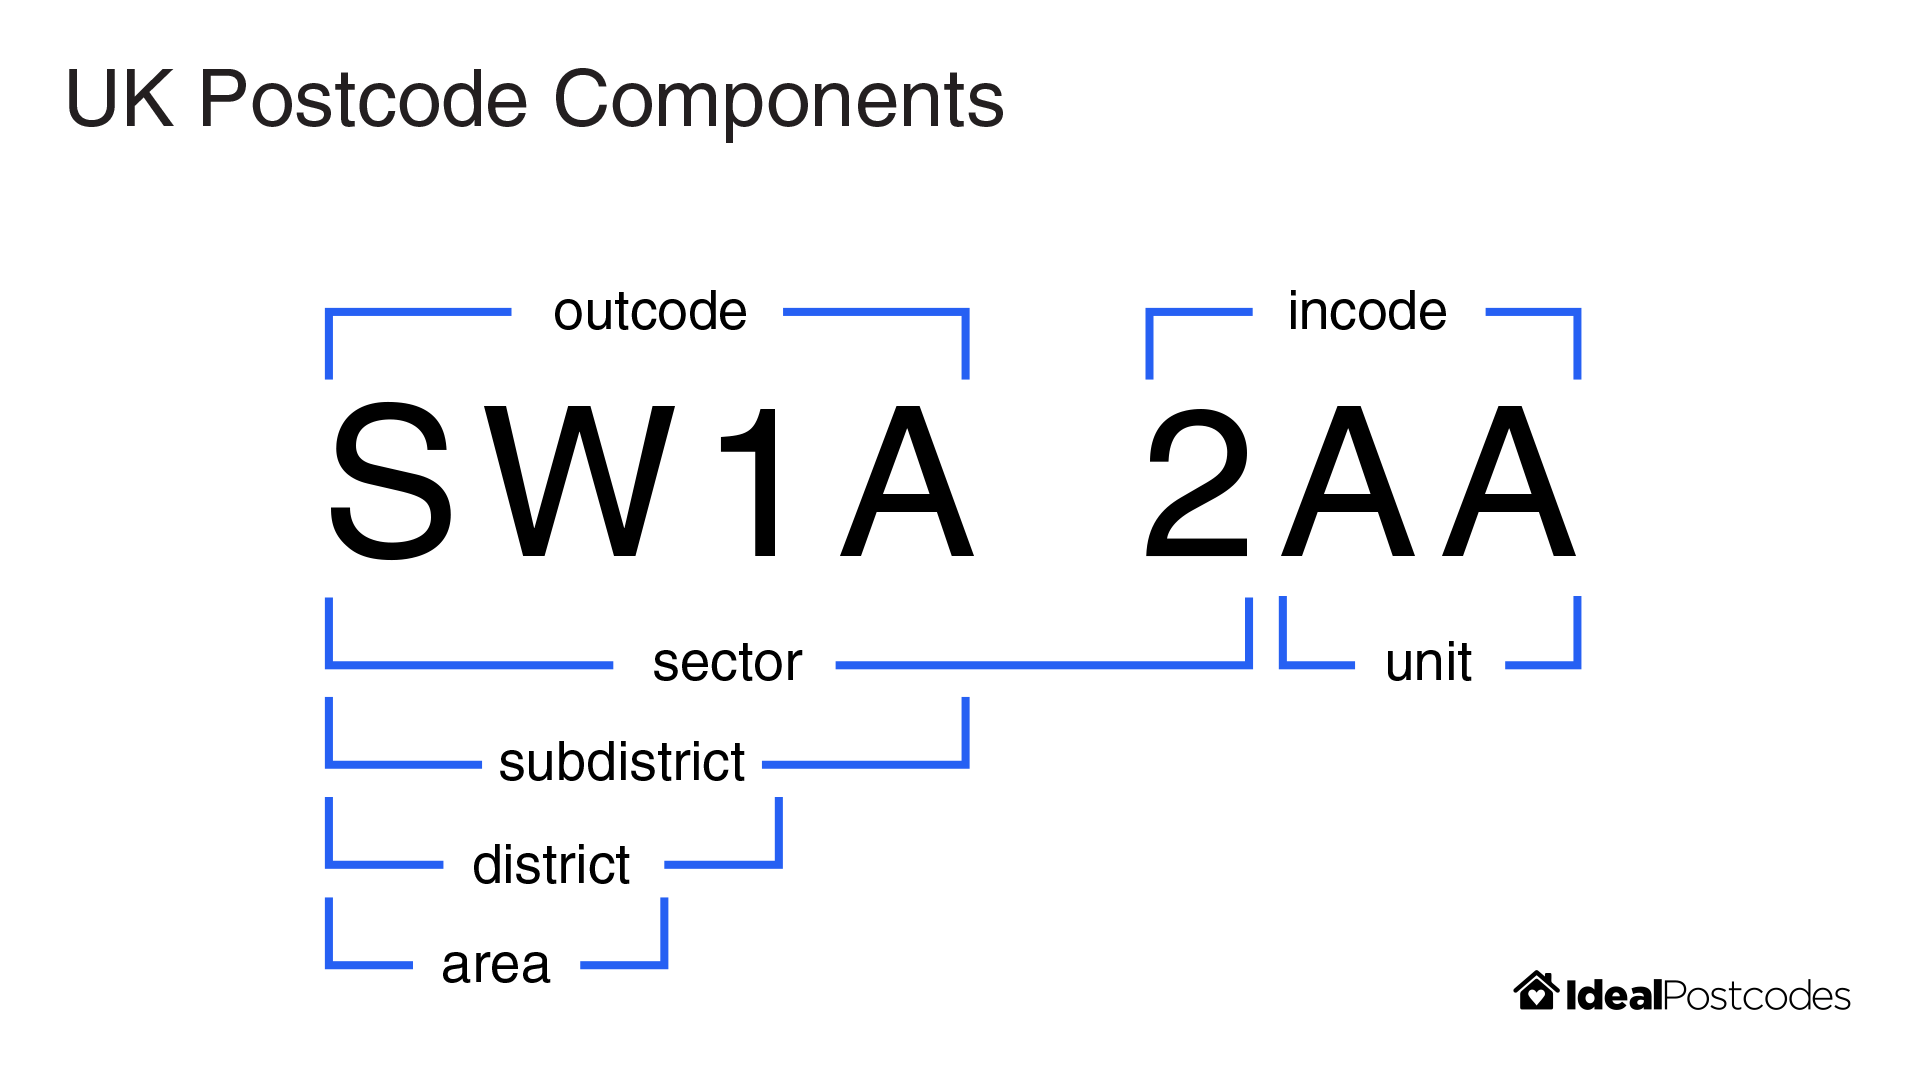

<br>
<font size="+1">
Now we're going to get the postcode boundary data and process it so we can also plot it in Bokeh, as tiles.  The following file contains all the postcode area shapefiles, derived from open data sources. Since it is a shapefile we can read it directly using geopandas:

In [7]:
# http://www.opendoorlogistics.com/wp-content/uploads/Data/UK-postcode-boundaries-Jan-2015.zip
map_sectors_df = gpd.read_file('UK-postcode-boundaries-Jan-2015\Distribution\Sectors.shp')

# We're just interested in the 'EH' postcode area for this demo:
map_sectors_df = map_sectors_df[map_sectors_df['name'].str.contains('EH')]

# Display a few lines covering an example of multipolygon:
map_sectors_df[map_sectors_df['name'].str.contains('EH22')].head(6)

,name,geometry
2968,EH22 1,"POLYGON ((-3.07606 55.89276, -3.07668 55.89269..."
2969,EH22 2,"POLYGON ((-3.01969 55.87864, -3.01991 55.88027..."
2970,EH22 3,"POLYGON ((-3.07606 55.89276, -3.07531 55.89230..."
2971,EH22 4,"POLYGON ((-3.07600 55.86287, -3.07877 55.86432..."
2972,EH22 5,"POLYGON ((-3.01969 55.87864, -3.01438 55.87581..."
2973,EH22 9,"MULTIPOLYGON (((-3.07073 55.89257, -3.07062 55..."


<br>
<font size="+1">
The geodataframe just has two columns, name: the postcode sector name and the geometry which is defined by polygon shapes. Note the MULTIPOLYGON shape in the last row. A multipolygon concept is not compatible with Bokeh so we will need to expand all those into constituent polygon rows using 'explode':

In [8]:
map_sectors_df = map_sectors_df.explode(index_parts=True)
map_sectors_df[map_sectors_df['name'].str.contains('EH22')].head(10)

name                                           geometry
2968 0  EH22 1  POLYGON ((-3.07606 55.89276, -3.07668 55.89269...
2969 0  EH22 2  POLYGON ((-3.01969 55.87864, -3.01991 55.88027...
2970 0  EH22 3  POLYGON ((-3.07606 55.89276, -3.07531 55.89230...
2971 0  EH22 4  POLYGON ((-3.07600 55.86287, -3.07877 55.86432...
2972 0  EH22 5  POLYGON ((-3.01969 55.87864, -3.01438 55.87581...
2973 0  EH22 9  POLYGON ((-3.07073 55.89257, -3.07062 55.89265...
     1  EH22 9  POLYGON ((-3.07237 55.89332, -3.07220 55.89315...

<br>
<font size="+1">
The sector EH22 9 has now become two POLYGON shapes instead of one MULTIPOLYGON shape. Now we're going to separate geometry column into x and y component parts - another thing we have to do to get the data into a compatible format for Bokeh. The following function enables us to do it as a vectored operation:

In [9]:
# The following function and apply method call from:
# https://kodu.ut.ee/~kmoch/geopython2019/L6/interactive-map-bokeh.html
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""
    exterior = row[geom].exterior

    if coord_type == 'x':
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        return list( exterior.coords.xy[1] )

<br>
<font size="+1">
Then, we apply the function twice, once for each x and y component:

In [10]:
map_sectors_df['x'] = map_sectors_df.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
map_sectors_df['y'] = map_sectors_df.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

<br>
<font size="+1">
Now we can drop the original geometry column and look at the bokeh compatible geodataframe:

In [11]:
# Drop the original geometry column which bokeh can't interpret
map_sectors_df = map_sectors_df.drop('geometry', axis=1)
map_sectors_df.head(5)

,,name,x,y
2914,0,EH1 1,"[-3.1942513328123625, -3.194189623975097, -3.1...","[55.94790568736242, 55.94792406413569, 55.9480..."
2915,0,EH1 2,"[-3.2007949858083022, -3.2007834195123515, -3....","[55.946194776123974, 55.946673758764426, 55.94..."
2916,0,EH1 3,"[-3.184762449295854, -3.1845674146433387, -3.1...","[55.95853553314363, 55.95847879366058, 55.9580..."
2917,0,EH1 9,"[-3.23151045166478, -3.232614575137067, -3.232...","[55.94287513616881, 55.94302242016989, 55.9433..."
2918,0,EH10 4,"[-3.2103094467874014, -3.2104096148470735, -3....","[55.92768518473048, 55.92808972919389, 55.9280..."


<br>
<font size="+1">
Finally, we can display the tiles in Bokeh. Note: we've added a hover tool also that will display the postcode sector when you hover over a tile.

In [12]:
# Define the data source
source = ColumnDataSource(map_sectors_df)

p = figure(title="EH Postcode Sectors", width=900, height=400)

# This will render each row in the data source as a patch
p.patches('x', 'y', source=source, fill_color='red',
          fill_alpha=0.5, line_color="black", line_width=0.15)

hover = HoverTool(tooltips = [
                              ('Sector', '@name'),
                              ])

p.add_tools(hover)

show(p)

# Combining the Map with the Postcode Tiles

<font size="+1">
Combining the map with the postcode tiles is very easy in Bokeh. We'll lay down the map tile and then render the tiles over the top with an alpha lower than 1 so that we can see underlying map. The main issue we have to deal with is getting the postcode data into the same projection system as the map.

In [13]:
map_sectors_df = gpd.read_file('UK-postcode-boundaries-Jan-2015\Distribution\Sectors.shp')
map_sectors_df = map_sectors_df[map_sectors_df['name'].str.contains('EH')]

# Convert the polygon coordinates to web mercator projection - which is the same as the openmap we're loading
map_sectors_df = map_sectors_df.to_crs(epsg=3857)
map_sectors_df.head(5)

,name,geometry
2914,EH1 1,"POLYGON ((-355582.432 7548052.134, -355575.562..."
2915,EH1 2,"POLYGON ((-356310.868 7547712.006, -356309.580..."
2916,EH1 3,"POLYGON ((-354526.134 7550165.678, -354504.423..."
2917,EH1 9,"POLYGON ((-359730.098 7547052.106, -359853.008..."
2918,EH10 4,"POLYGON ((-357370.013 7544033.270, -357381.164..."


<br>
<font size="+1">
As before, we explode the multipolygons and split them into constituent x and y components: 

In [14]:
map_sectors_df = map_sectors_df.explode(index_parts=True)

map_sectors_df['x'] = map_sectors_df.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
map_sectors_df['y'] = map_sectors_df.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

map_sectors_df = map_sectors_df.drop('geometry', axis=1)

<br>
<font size="+1">
In this combined version, we're going to add some more information to the hover tool - the name of the town/area that the postcode district covers:

In [15]:
map_sectors_df['postcode_district'] = [x.split(' ')[0] for x in map_sectors_df['name']]

# Data from: https://www.doogal.co.uk/PostcodeDistricts
postcode_to_name_df = pd.read_csv('Postcode districts.csv', index_col='Postcode')
postcode_to_name_df = postcode_to_name_df.rename(columns={"Town/Area":"TownArea"})

map_sectors_df = map_sectors_df.merge(postcode_to_name_df['TownArea'], how="left", 
                                      left_on="postcode_district", right_index=True)

map_sectors_df.head(5)

,,name,x,y,postcode_district,TownArea
2914,0,EH1 1,"[-355582.4318344076, -355575.56243806577, -355...","[7548052.133741504, 7548055.787115032, 7548076...",EH1,Old Town
2915,0,EH1 2,"[-356310.8679538435, -356309.5803996679, -3563...","[7547712.005571655, 7547807.225530352, 7547808...",EH1,Old Town
2916,0,EH1 3,"[-354526.1341531532, -354504.42299494817, -354...","[7550165.6777762035, 7550154.394661121, 755006...",EH1,Old Town
2917,0,EH1 9,"[-359730.09797246475, -359853.0084351727, -359...","[7547052.105921023, 7547081.382794873, 7547138...",EH1,Old Town
2918,0,EH10 4,"[-357370.0129052093, -357381.1635626058, -3573...","[7544033.269782145, 7544113.653214607, 7544113...",EH10,"Bruntsfield, Morningside, Fairmilehead"


<br>
<font size="+1">
Now everything is ready in the data source, we can render our map with the postocd eoverlay and hover tool:

In [16]:
source = ColumnDataSource(map_sectors_df)

# Edinburgh area
lat, lon = 55.8, -3.06

EN = lnglat_to_meters(lon, lat)
dE = 60000 # (m) Easting  plus-and-minus from map center
dN = 60000 # (m) Northing plus-and-minus from map center

x_range = (EN[0]-dE, EN[0]+dE) # (m) Easting  x_lo, x_hi
y_range = (EN[1]-dN, EN[1]+dN) # (m) Northing y_lo, y_hi

# Make the figure
p = figure(x_range=x_range, y_range=y_range,
                  x_axis_type="mercator", y_axis_type="mercator",
                  height=400, width=900)

# Add the map
p.add_tile("OpenStreetMap Mapnik")

# Add the postcode tiles (patches)
p.patches('x', 'y', source=source, fill_color='red',
          fill_alpha=0.2, line_color="black", line_width=0.5)

# New hover tool with the extra town/area information
hover = HoverTool(tooltips = [
                              ('Sector', '@name'),
                              ('Town/Area', '@TownArea')
                              ])

p.add_tools(hover)

show(p)

<br>
<font size="+1">
You can use the tools on the right to zoom in and out, pan etc. 

<br>
<font size="+1">
And that's it! I hope this was useful. The biggest challenge I faced was trying to do this with down-level versions of various packages under the hood. Once I made a fresh environment with just the minimum packages needed, it went a lot better.